In [1]:
import pygco
import scipy
import igraph
import numpy
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
numpy.random.seed(seed=23)

In [3]:
n_nodes = 20
n_labels = 2

var = 2
mu0 = -2
mu1 = 2

In [4]:
base = 1.0 - numpy.eye(int(n_nodes/2))
adj = scipy.linalg.block_diag(base, base)

In [5]:
adj[9, 10] = adj[10, 9] = 1
adj[:, 0] = adj[0, :] = 0
adj[0, 1] = adj[1, 0] = 1
adj[:, 19] = adj[19, :] = 0
adj[18, 19] = adj[19, 18] = 1

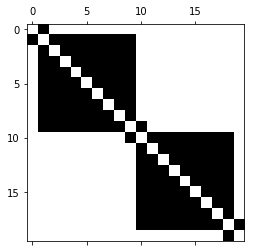

In [6]:
plt.spy(adj)
plt.savefig("_fig/adj.pdf", dpi=720)
plt.savefig("_fig/adj.png", dpi=720)
plt.show()

In [7]:
labels = numpy.ones(int(n_nodes), dtype="int")
labels[10:] = 2
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
X0 = numpy.random.normal(mu0, var, 1000) 
X1 = numpy.random.normal(mu1, var, 1000)

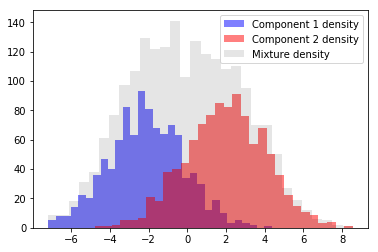

In [9]:
fig, ax = plt.subplots()
ax.hist(X0, color='blue', alpha=0.5, bins=30, label="Component 1 density")
ax.hist(X1, color='red', alpha=0.5, bins=30, label="Component 2 density")
ax.hist(numpy.append(X0, X1), color='black', alpha=.1, bins=30, label="Mixture density")
ax.legend(loc="upper right")
plt.savefig("_fig/density.pdf", dpi=720)
plt.savefig("_fig/density.png", dpi=720)
plt.show()

In [10]:
X = numpy.append(numpy.random.normal(mu0, var, int(n_nodes/2)) ,
                 numpy.random.normal(mu1, var, int(n_nodes/2)))

In [11]:
# use a custom color palette
colrs = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']

In [12]:
# create 10 bins from the data
bins = numpy.linspace(min(X), max(X), 10)
# assign bin index to values from X
digitized = list(numpy.digitize(X, bins))

In [13]:
# create an undirected graph object
g = igraph.Graph.Adjacency(adj.tolist(), mode=igraph.ADJ_UNDIRECTED)

In [14]:
g.es["width"] = .5
for i in range(n_nodes):
    g.vs[i]['color'] = str(colrs[digitized[i]])
    g.vs[i]['label'] = i

In [15]:
layout = g.layout_kamada_kawai()

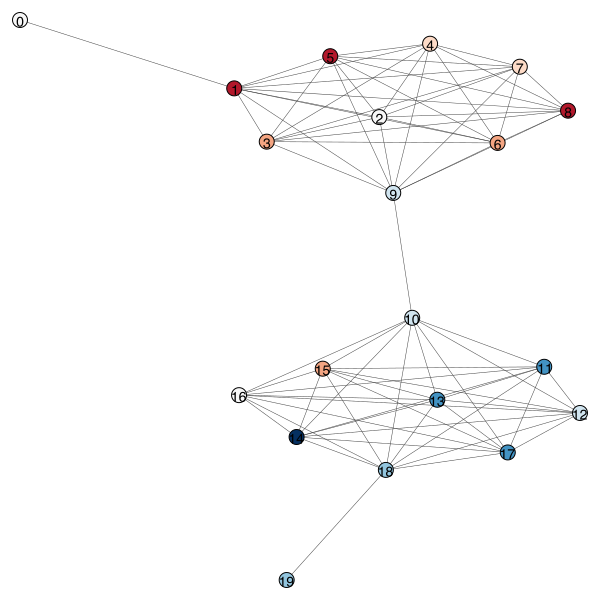

In [16]:
igraph.plot(g, vertex_size = 15, layout=layout)

In [17]:
g.write_svg("_fig/graph_obs.svg", vertex_size=15, layout=layout)

In [18]:
costs = numpy.ones(shape=[n_labels, n_nodes], dtype="float") * numpy.nan
costs[0, :] = norm.pdf(X, loc=mu0, scale=var)
costs[1, :] = norm.pdf(X, loc=mu1, scale=var)

In [19]:
# some parameter as defined in the original paper by Robinson et al. (2017), Bioinformatics
beta = .9

In [20]:
# set edge list
edges = numpy.array(g.get_edgelist())
# set edge weigths
edge_weights = numpy.ones(len(edges))
# set unary potentials as NLLs from the two classes
unary_costs = -numpy.log(costs.T) * 1000
# set pairwise costs as complementary 
pairwise_costs = beta *( 1.0 - numpy.eye(n_labels)) * 1000

In [21]:
# do a grpah cut to infer labels of the data
min_energy_labels = pygco.cut_general_graph(edges, edge_weights, unary_costs, pairwise_costs)

In [22]:
min_energy_labels

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1], dtype=int32)

In [23]:
g.es["width"] = .5
for i in range(n_nodes):
    g.vs[i]['label'] = i
    if min_energy_labels[i] == 1:
        g.vs[i]['color'] = "#b2182b"
    else:
        g.vs[i]['color'] = "#2166ac"

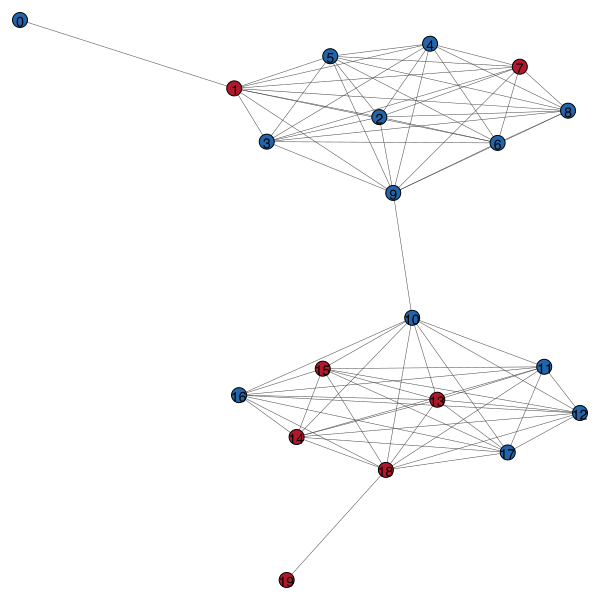

In [24]:
igraph.plot(g, vertex_size = 15, layout=layout)

In [25]:
g.write_svg("_fig/graph_labels.svg", vertex_size=15, layout=layout)